[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


MAE: 0.21513812499999999


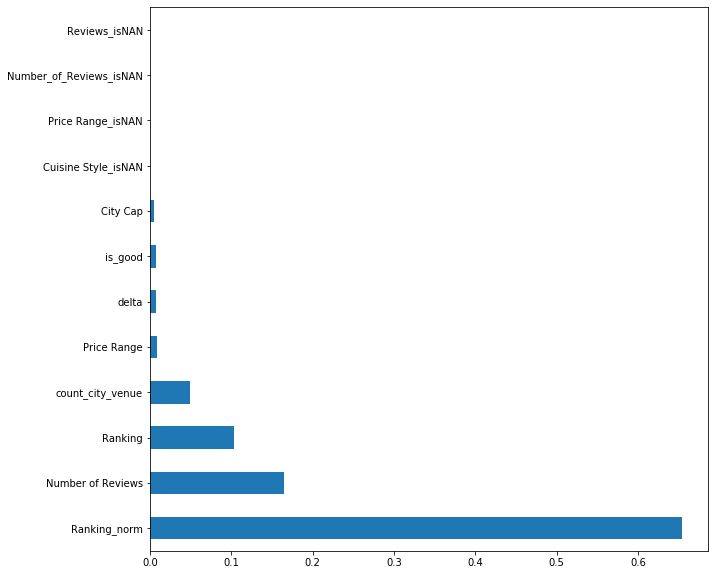

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

data['Cuisine Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Price Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Reviews_isNAN'] = pd.isna(data['Reviews']).astype('uint8')

# Далее заполняем пропуски
data['Number of Reviews'].fillna(0, inplace=True)
data['Price Range'].fillna('$$ - $$$', inplace=True)
data['Cuisine Style'].fillna('Common', inplace=True)
data['Reviews'].fillna('[]', inplace=True)

import re
def review_time(row):
    match = re.findall('\d\d/\d\d/\d\d\d\d', row['Reviews'])
    if len(match) == 0:
        return [pd.to_datetime('10/25/2017', format='%m/%d/%Y'), pd.to_datetime('10/25/2017', format='%m/%d/%Y')]
    elif len(match) == 1:
        return [pd.to_datetime(match[0], format='%m/%d/%Y'), pd.to_datetime('10/25/2017', format='%m/%d/%Y')]
    return [pd.to_datetime(match[0], format='%m/%d/%Y'), pd.to_datetime(match[1], format='%m/%d/%Y')]

def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...

    # тут ваш код по обработке NAN
    # ....
    
    df_output['Cuisine Style_isNAN'] = pd.isna(df_output['Cuisine Style']).astype('uint8')
    df_output['Price Range_isNAN'] = pd.isna(df_output['Price Range']).astype('uint8')
    df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    df_output['Reviews_isNAN'] = pd.isna(df_output['Reviews']).astype('uint8')

# Далее заполняем пропуски
 
    df_output['Number of Reviews'].fillna(0, inplace=True)
    df_output['Price Range'].fillna('$$ - $$$', inplace=True)
    df_output['Cuisine Style'].fillna('Common', inplace=True)
    df_output['Reviews'].fillna('[]', inplace=True)

    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    #df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    #le = LabelEncoder()
    #df_output['City Code'] = le.fit_transform(df_input['City'])
    
    price_range_dict = {
    '$': 1,
    '$$ - $$$': 2,
    '$$$$': 3
    }
    df_output['Price Range'] = df_output['Price Range'].map(price_range_dict)
    
    # тут ваш код на Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код на генерацию новых фичей
    # ....
    df_output['Ranking_norm'] = df_input['Ranking'] / df_input['City'].map(df_input.groupby(['City'])['Ranking'].max())
    #df_output.drop(['Ranking'], axis=1, inplace=True)
    
    #Количеcтво ресторанов на город, берем по максимальному значению Ranking
    df_output['count_city_venue'] = df_input['City'].map(df_input.groupby(['City'])['Ranking'].max().to_dict())
    
    
    df_temp = df_output.apply(review_time, axis=1, result_type='expand')
    fake = pd.to_datetime('10/25/2017',  format='%m/%d/%Y')
    t5 = df_temp.apply(lambda x: (x[0]-x[1]).days if not x[0] == fake or not x[1] == fake else 100000, axis=1)
    df_output['delta'] = t5.apply(lambda x: 0 if x > 64 else 1)

    df_output['is_good'] = df_input['Reviews'].apply(lambda x: 0 if pd.isna(re.search("Good|good|excellent|Excellent|awesome|Awesome|Best|best|Nice|nice", str(x))) else 1)
    
    #City is capital?
    
    capitals = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague', 
            'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm', 
            'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens', 
            'Oslo', 'Helsinki', 'Bratislava', 'Luxembourg', 'Ljubljana','Edinburgh']
    
    df_output['City Cap'] = df_input['City'].apply(lambda x: 1 if x in capitals else 0)
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

df_preproc = preproc_data(data)


# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)



# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)



# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)


# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)



# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))



# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

